In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torchvision
from pytorch_lightning import LightningModule, Trainer
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2

import torchvision.transforms as transforms

import cv2
import glob
import matplotlib.pyplot as plt
import copy 
%matplotlib inline

In [2]:
train_transform = A.Compose(
    [   
        A.Resize(50, 50),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
val_transform = A.Compose(
    [   A.Resize(50, 50),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

In [3]:
CLASSES = len(glob.glob('TrainIJCNN2013/TrainIJCNN2013' + '/*/'))
CLASSES

43

In [4]:
list_train = glob.glob('TrainIJCNN2013/TrainIJCNN2013' + '/*/*')
list_train = [string for string in list_train if '.ppm' in string]

In [5]:
train, val = train_test_split(list_train, train_size=0.8, )

In [6]:
class MyDataset(Dataset):

    def __init__(self,
     list_names, transform):
        self.list_names = list_names
        self.transform = transform

    def get_img(self, idx):
        name = self.list_names[idx]
        image =  cv2.imread(name)
        class_ = name.split('/')[-2]
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        return image, int(class_)

    def __len__(self):
        return len(self.list_names)
    
    def __getitem__(self, idx):
        img, class_ = self.get_img(idx)
        if self.transform is not None:
            img = self.transform(image=img)["image"]
        return img, class_ 

In [7]:
dataset_train = MyDataset(train, train_transform)
dataset_val = MyDataset(val, val_transform)

In [8]:
dataset_train[0][0].shape

torch.Size([3, 50, 50])

In [9]:
def visualize_augmentations(dataset, idx=0, samples=10, cols=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i in range(samples):
        image, _ = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

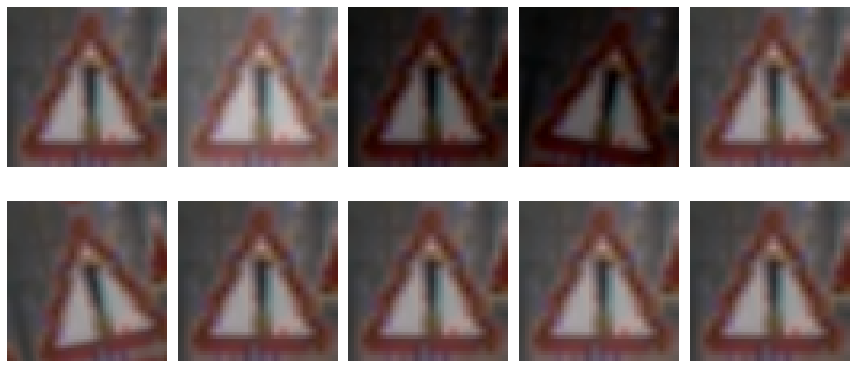

In [10]:
visualize_augmentations(dataset_train, idx=9)


In [11]:
train_dataloader = DataLoader(dataset_train, batch_size=12, 
                              num_workers=12, 
                              shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=12, 
                            num_workers=12,
                            )

In [12]:
def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()/len(labels)

In [14]:
model = torchvision.models.resnet18()
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, CLASSES),
    # nn.LogSoftmax(dim=1),
)

loss = nn.CrossEntropyLoss()

In [49]:
class ClassModel(LightningModule):
    def __init__(
        self,
        lr: float = 0.001,
    ):
        super().__init__()
        self.lr = lr
        self.net = model
        self.loss = loss
        self.metric = accuracy

    def forward(self, x):
        return self.net(x)

    def training_step(self, batch, _):
        img, classes = batch
        out = self(img.float())
        loss_train = self.loss(out, classes)
        self.log('train_step', loss_train, on_step=True, )
        return loss_train

    def validation_step(self, batch, _):
        img, classes = batch
        out = self(img.float())
        metric = self.metric(out, classes)
        self.log('val_metric_step', metric, on_step=True)
        return metric

    def validation_epoch_end(self, outputs):
        loss_val = torch.tensor(outputs).mean() if outputs else 0
        self.log('val_epoch_total_step', loss_val, on_epoch=True)
        return loss_val

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.net.parameters(), lr=self.lr)
        scheduler = {
            'scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min'),
            'monitor' : 'train_step',
        }
        return {
                "optimizer": optimizer,
                "lr_scheduler": scheduler,
                }


In [50]:
from pytorch_lightning.callbacks import ModelCheckpoint

In [51]:
model = ClassModel()
checkpoint_callback = ModelCheckpoint(dirpath="lightning_logs/classification/best__resnet50", mode='max', save_top_k=2, monitor="val_epoch_total_step")

In [52]:
trainer = Trainer(gpus=1,
 max_epochs=30,
 callbacks=[checkpoint_callback]
 )

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [53]:
trainer.fit(model,
 train_dataloader, val_dataloader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type             | Params
------------------------------------------
0 | net  | ClassModel       | 11.2 M
1 | loss | CrossEntropyLoss | 0     
------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.794    Total estimated model params size (MB)
/home/tims/miniconda3/envs/geo/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:623: UserWarning: Checkpoint directory /home/tims/work/myprojects/traffic/lightning_logs/classification/best__resnet50 exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check: 0it [00:00, ?it/s]

tensor(0.8750)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

tensor(0.8889)


Validating: 0it [00:00, ?it/s]

tensor(0.9056)


Validating: 0it [00:00, ?it/s]

tensor(0.8889)


Validating: 0it [00:00, ?it/s]

/home/tims/miniconda3/envs/geo/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:685: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [ ]:
# model = model.load_from_checkpoint(checkpoint_path='lightning_logs/classification/best__resnet50/epoch=0-step=85.ckpt')

In [19]:
images, classes = next(iter(val_dataloader))

In [20]:
model.eval()
preds = model(images.to('cuda'))

In [25]:
preds.shape

torch.Size([12, 43])

In [22]:
preds.argmax(dim=1)

tensor([ 2,  8,  5, 14, 28, 41,  1,  3, 11, 38,  2,  2], device='cuda:0')

In [26]:
classes

12

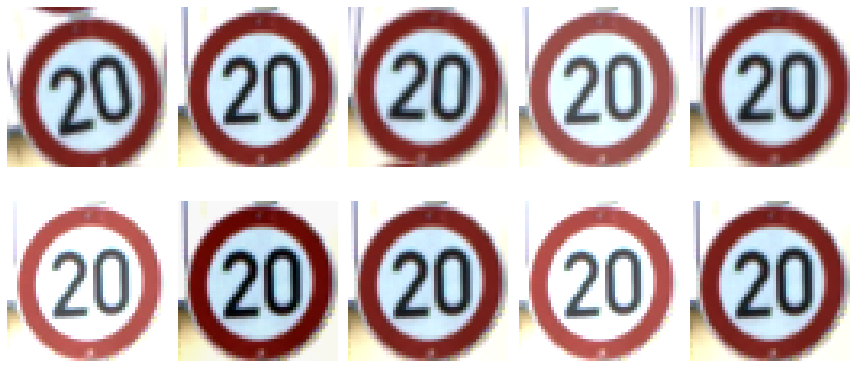

In [ ]:
visualize_augmentations(dataset_train, idx=300)


In [20]:
torch.save(model, 'classification_model_2.pt')